In [71]:
# script libraries
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, BatchNormalization
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist
from tqdm import tqdm

## Setup Code

In [72]:
# load in padded dataset
chonky_padded_waveforms = pd.read_parquet('padded_waveforms.parquet')
# us to timesteps
us2timesteps = 100
# finalising the data arrays
padded_array = chonky_padded_waveforms['chonkers'].to_numpy()
x_data = np.stack(padded_array, axis=0)
# divide by max phd
max_phd = x_data.max()
x_data = x_data / max_phd
# set all values less than zero (probs due to noise) to zero. I think this is the correct way to do this?
x_data[x_data < 0] = 0
# waveform intensity range should now be between zero and 1.
print(x_data.min())
print(x_data.max())
print(x_data.shape)
y_data = chonky_padded_waveforms['label'].to_numpy().reshape((-1,1))
print(y_data.shape)
input_length = x_data.shape[-1]
print(input_length)

0.0
1.0
(7782, 3028)
(7782, 1)
3028


In [73]:
# get training and testing sets
runID = chonky_padded_waveforms['runID']
eventID = chonky_padded_waveforms['eventID']
W_array = chonky_padded_waveforms['weights_no_gas'].to_numpy()
X_train, X_test, \
y_train, y_test, \
W_train, W_test, \
runID_train, runID_test, \
eventID_train, eventID_test = \
train_test_split(x_data, y_data, W_array, runID, eventID, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_train)
print(y_train)
X_train_reshaped = np.expand_dims(X_train, axis=-1)
print(X_train_reshaped.shape)

print(W_train.shape)

(5836, 3028)
(5836, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[2]
 [2]
 [2]
 ...
 [1]
 [1]
 [1]]
(5836, 3028, 1)
(5836,)


In [74]:
CNN_model = keras.Sequential([
        keras.layers.Conv1D(filters=6,kernel_size=900,activation='relu', input_shape=(input_length, 1)),
        # keras.layers.Masking(mask_value=0, input_shape=(input_length, 1)),
        # keras.layers.Conv1D(filters=6,kernel_size=900,activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(3, activation='softmax')
    ])

CNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2129, 6)           5406      
                                                                 
 flatten_5 (Flatten)         (None, 12774)             0         
                                                                 
 dense_5 (Dense)             (None, 3)                 38325     
                                                                 
Total params: 43731 (170.82 KB)
Trainable params: 43731 (170.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
CNN_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00004),
                  loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                  metrics=['accuracy'],
                  weighted_metrics=['accuracy'])

In [76]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=8)
hist_cnn_model = CNN_model.fit(X_train,y_train,epochs=150, validation_split=0.2, shuffle=True, sample_weight=W_train, callbacks=[callback])

Epoch 1/100
146/146 [==============================] - 5s 29ms/step - loss: 0.0344 - accuracy: 0.5242 - weighted_accuracy: 0.5926 - val_loss: 0.0265 - val_accuracy: 0.5634 - val_weighted_accuracy: 0.7377
Epoch 2/100
146/146 [==============================] - 4s 27ms/step - loss: 0.0224 - accuracy: 0.7230 - weighted_accuracy: 0.7964 - val_loss: 0.0195 - val_accuracy: 0.6789 - val_weighted_accuracy: 0.8032
Epoch 3/100
146/146 [==============================] - 4s 28ms/step - loss: 0.0181 - accuracy: 0.7611 - weighted_accuracy: 0.8389 - val_loss: 0.0165 - val_accuracy: 0.7748 - val_weighted_accuracy: 0.8496
Epoch 4/100
146/146 [==============================] - 4s 26ms/step - loss: 0.0163 - accuracy: 0.7933 - weighted_accuracy: 0.8607 - val_loss: 0.0154 - val_accuracy: 0.7731 - val_weighted_accuracy: 0.8628
Epoch 5/100
146/146 [==============================] - 4s 25ms/step - loss: 0.0152 - accuracy: 0.7971 - weighted_accuracy: 0.8659 - val_loss: 0.0144 - val_accuracy: 0.8348 - val_weight

In [77]:
test_loss, test_acc, test_weight_acc = CNN_model.evaluate(X_test,y_test, sample_weight=W_test)

61/61 [==============================] - 1s 16ms/step - loss: 0.0126 - accuracy: 0.8541 - weighted_accuracy: 0.8961


## Figuring out how the best model learns

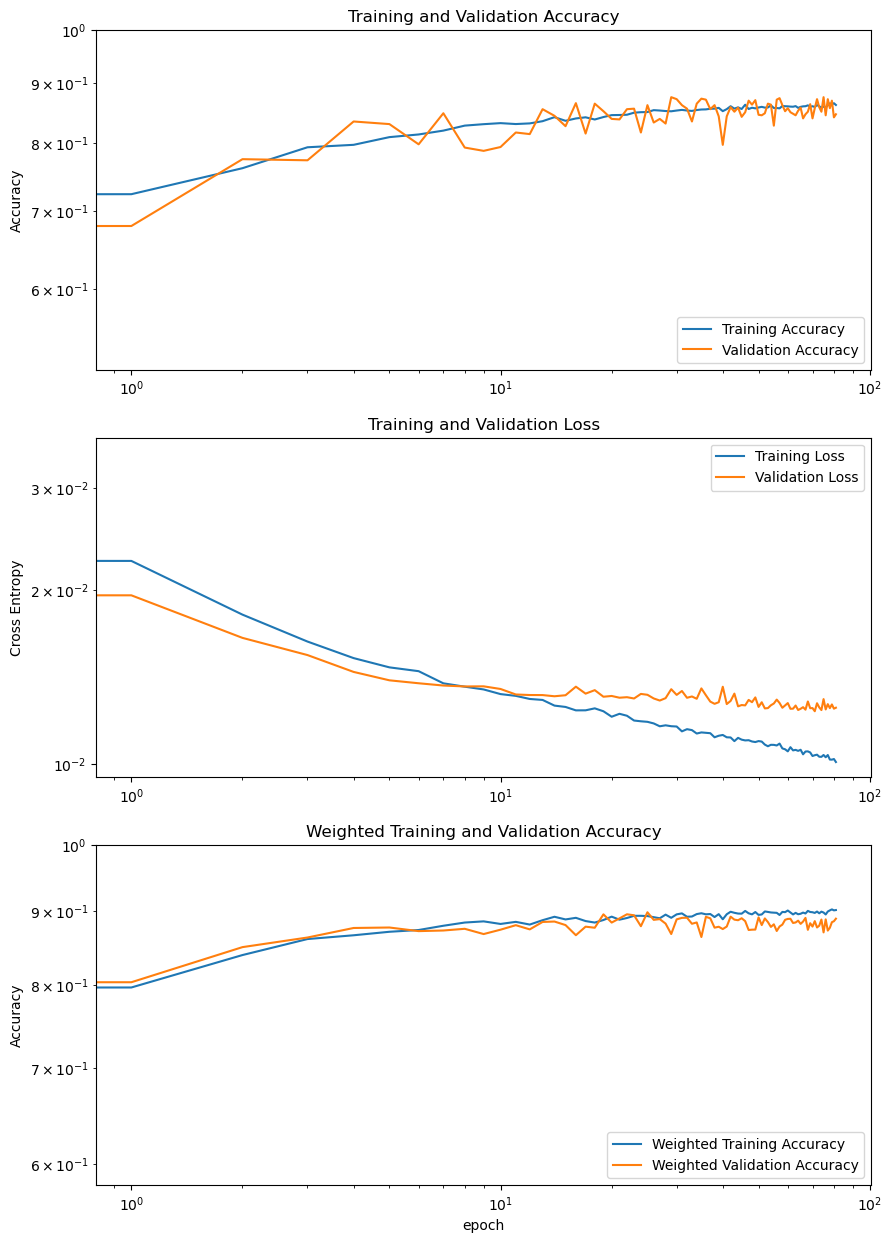

In [78]:
# plotting training history

acc = hist_cnn_model.history['accuracy']
val_acc = hist_cnn_model.history['val_accuracy']
w_acc = hist_cnn_model.history['weighted_accuracy']
w_val_acc = hist_cnn_model.history['val_weighted_accuracy']

loss = hist_cnn_model.history['loss']
val_loss = hist_cnn_model.history['val_loss']
# w_loss = hist_paddedCNN.history['weighted_loss']
# w_val_loss = hist_paddedCNN.history['val_weighted_loss']

plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1)
plt.loglog(acc, label='Training Accuracy')
plt.loglog(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.loglog(loss, label='Training Loss')
plt.loglog(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

# plotting weighted mertrics

plt.subplot(3, 1, 3)
plt.loglog(w_acc, label='Weighted Training Accuracy')
plt.loglog(w_val_acc, label='Weighted Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Weighted Training and Validation Accuracy')
plt.xlabel('epoch')

plt.show()

In [79]:
# generating confusion matrix info

y_predicted = CNN_model.predict(X_test) # these are the "probabilities" associated with the classification
y_predicted_label = [np.argmax(i) for i in y_predicted] # these are the predictions

61/61 [==============================] - 1s 7ms/step


Text(95.72222222222221, 0.5, 'Truth')

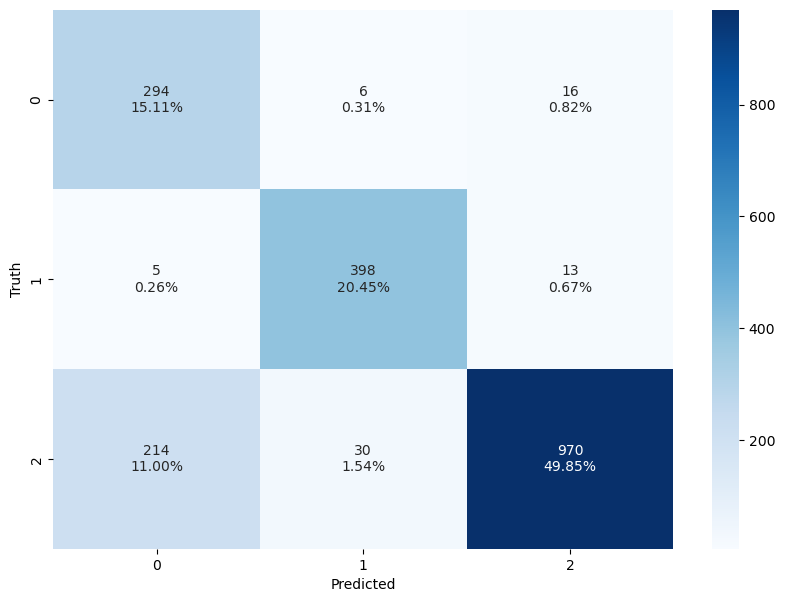

In [80]:
# plotting confusion matrix

# plt.figure(figsize = (10,7))
# sns.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label),
#            annot=True, 
#            fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

plt.figure(figsize = (10,7))
cf_matrix = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label).numpy()

# group_names = ['True Cathode','False Gate', 'False Signal', 
#                'False Cathode','True Gate', 'False Signal',
#                'False']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
#labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
          #zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [81]:
print(y_test.shape)
print(y_predicted.shape)

print(classification_report(y_test, y_predicted_label, labels=[0, 1, 2], target_names=['cathode', 'gate', 'tritium'], sample_weight=W_test))

(1946, 1)
(1946, 3)
              precision    recall  f1-score   support

     cathode       0.84      0.94      0.89 25.833554354852332
        gate       0.95      0.95      0.95 24.41004528834838
     tritium       0.91      0.79      0.85 24.789000241589495

    accuracy                           0.90 75.0325998847902
   macro avg       0.90      0.90      0.90 75.0325998847902
weighted avg       0.90      0.90      0.90 75.0325998847902



In [82]:
# For ROC AUC, assuming `y_pred_proba` is the prediction probabilities and `y_true` is label encoded
roc_auc = roc_auc_score(y_test, y_predicted, sample_weight=W_test, multi_class="ovr")
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.9671724917733137


## best first layer activation maps 

In [83]:
# Assume `model` is your original CNN model and 'conv_layer_name' is the name of the layer you want to inspect
layer_outputs = [layer.output for layer in CNN_model.layers if layer.name == 'conv1d']
activation_model = Model(inputs=CNN_model.input, outputs=layer_outputs)

(1, 3028, 1)
(3028,)


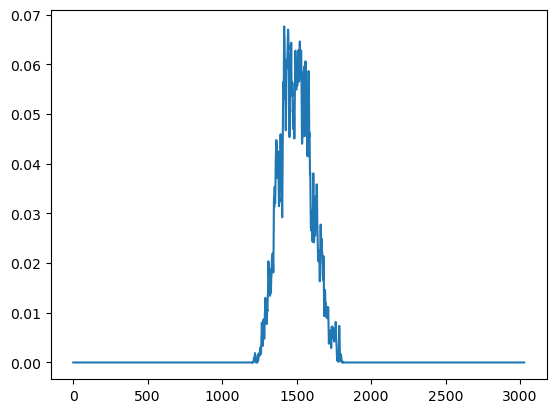

1/1 [==============================] - 0s 24ms/step


IndexError: list index out of range

In [84]:
print(X_test[1000,:].reshape(1, input_length, 1).shape)
print(X_test[1000].shape)

plt.figure()
plt.plot(X_test[1000,:])
plt.show()

activations = activation_model.predict(X_test[1000].reshape(1, input_length, 1))

# print(chonky_padded_waveforms[chonky_padded_waveforms.length == len(X_test[1000])])

(2129, 6)
6


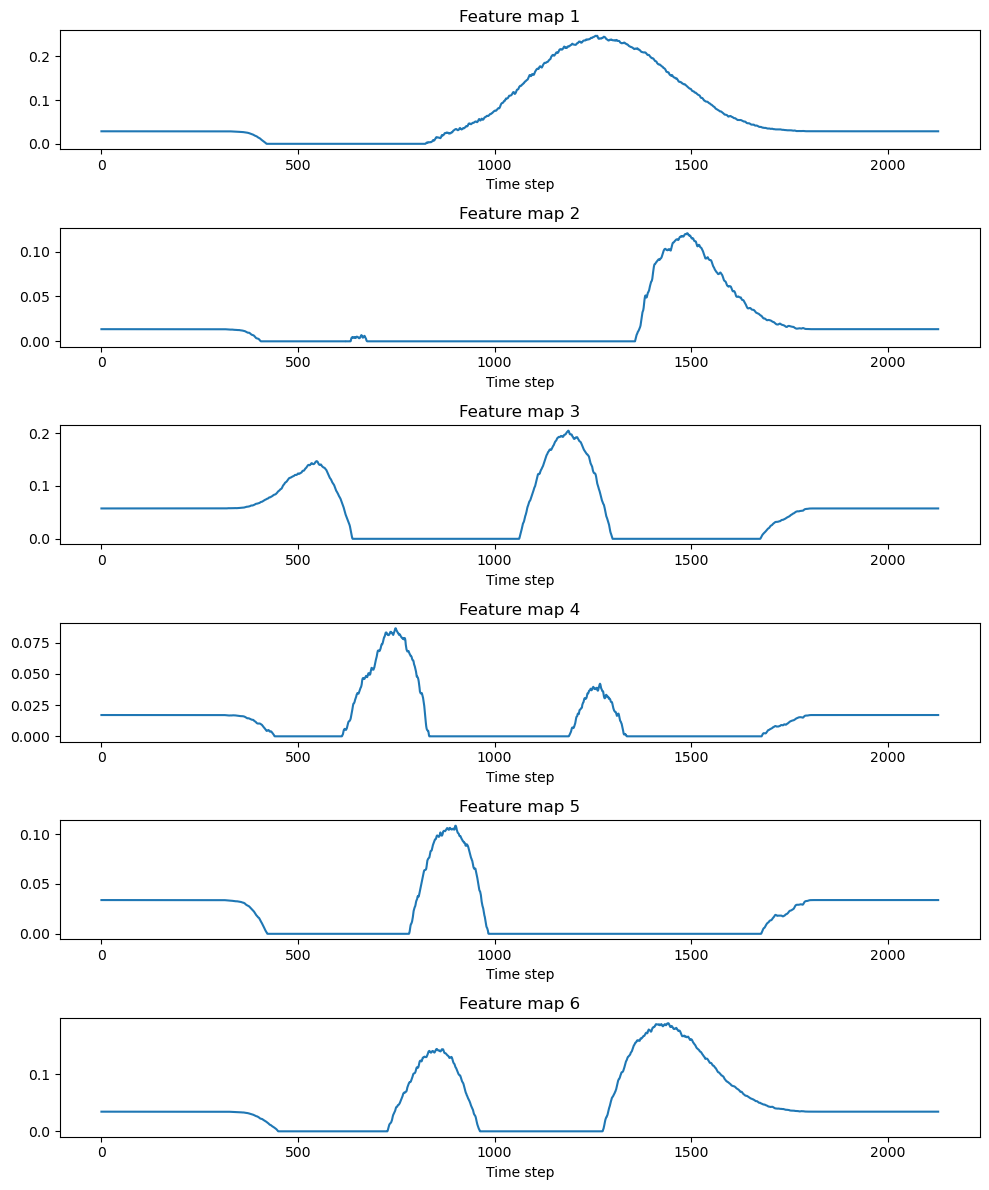

In [ ]:
# Assuming you're visualizing the first layer's activations for simplicity
first_layer_activations = activations[0]
print(first_layer_activations.shape)

# Choose how many features maps you'd like to display
n_features = first_layer_activations.shape[-1]
print(n_features)

# Prepare the plot
fig, axes = plt.subplots(n_features, 1, figsize=(10, n_features * 2))

if n_features == 1:
    axes = [axes]  # Ensure axes is iterable for a single feature map

for i, ax in enumerate(axes):
    # Plot each activation map
    feature_map = first_layer_activations[:, i]
    ax.plot(feature_map)
    ax.set_title(f'Feature map {i+1}')
    ax.set_xlabel('Time step')
    plt.tight_layout()

plt.show()